In [161]:
%load_ext autoreload
%autoreload 2

from collections import deque
import matplotlib.pyplot as plt

import numpy as np
import torch 

import gym

from network import Network
from policy import Policy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



_____________
#### Exploration de l'environnement

In [2]:
env = gym.make('CartPole-v0')

print(f'''
*** environnement : {env.spec} ***
\r\nobservation space : {env.observation_space}
action space : {env.action_space}
reward range : {env.reward_range}
''')


*** environnement : EnvSpec(CartPole-v0) ***

observation space : Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space : Discrete(2)
reward range : (-inf, inf)



### Hill Climbing 

#### Vanilla Hill Climbing

In [ ]:
%%time

policy = Policy(state_size=4, action_size=2, hiden_layer_size=8)
render = False
#---- hypp
SCALE = .5
N_EPISODE = 100
AVERAGE_ON_RECORD = 1
#----

scores_record = deque()
scores_window = deque(maxlen=AVERAGE_ON_RECORD)

best_score = 0

for i in range(N_EPISODE):

    done = False
    state = env.reset()
    score = 0
    
    while not done:
        if render:
            env.render()
        action = policy.act(state)
        next_state, reward, done, info = env.step(action)
        state = next_state
        score += reward
    
    if score >= best_score:
        best_score = score
        policy.best_w = policy.w
    
    policy.add_noise(SCALE)
    
    scores_window.append(score)
    if len(scores_window) == AVERAGE_ON_RECORD:
        scores_record.append(np.mean(scores_window))
        scores_window = deque()
    
if render:
    env.close()

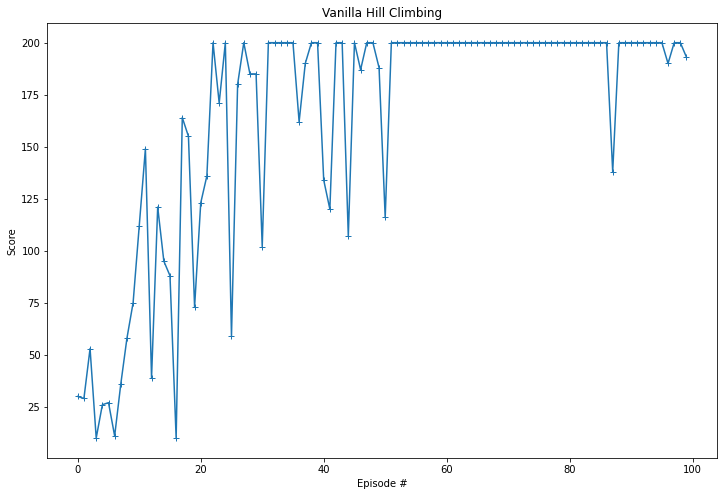

In [235]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_record))*AVERAGE_ON_RECORD, scores_record, marker='+')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Vanilla Hill Climbing')
plt.show()

#### Hill Climbing simulated anneling

In [242]:
%%time

policy = Policy(state_size=4, action_size=2, hiden_layer_size=8)
render = False
AVERAGE_ON_RECORD = 1

#---- hypp
SCALE_INIT = 1
SCALE_UPDATE = .95
SCALE_MIN = 1e-4
N_EPISODE = 100
#----

scores_record = deque()
scores_window = deque(maxlen=AVERAGE_ON_RECORD)

scale = SCALE_INIT
best_score = 0

for i in range(N_EPISODE):

    done = False
    state = env.reset()
    score = 0
    
    while not done:
        if render:
            env.render()
        action = policy.act(state)
        next_state, reward, done, info = env.step(action)
        state = next_state
        score += reward
    
    if score >= best_score:
        best_score = score
        policy.best_w = policy.w
        
    scale = max(scale * SCALE_UPDATE, SCALE_MIN)
    policy.add_noise(scale)
    
    scores_window.append(score)
    if len(scores_window) == AVERAGE_ON_RECORD:
        scores_record.append(np.mean(scores_window))
        scores_window = deque()
    
if render:
    env.close()

Wall time: 1.05 s


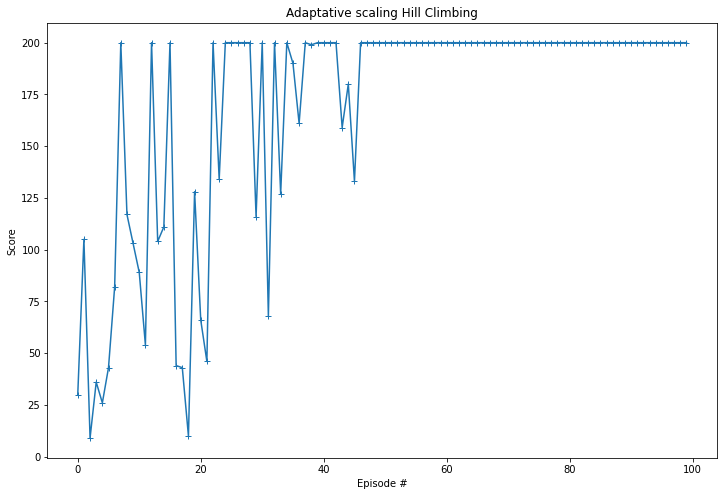

In [243]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_record))*AVERAGE_ON_RECORD, scores_record, marker='+')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Adaptative scaling Hill Climbing')
plt.show()

#### Hill Climbing adaptative scaling

In [238]:
%%time

policy = Policy(state_size=4, action_size=2, hiden_layer_size=8)
render = False
AVERAGE_ON_RECORD = 1

#---- hypp
SCALE_INIT = .5
SCALE_UPDATE = 1.5
SCALE_MIN = 1e-4
SCALE_MAX = 2
N_EPISODE = 100
#----

scores_record = deque()
scores_window = deque(maxlen=AVERAGE_ON_RECORD)

scale = SCALE_INIT
best_score = 0

for i in range(N_EPISODE):

    done = False
    state = env.reset()
    score = 0
    
    while not done:
        if render:
            env.render()
        action = policy.act(state)
        next_state, reward, done, info = env.step(action)
        state = next_state
        score += reward
    
    if score >= best_score:
        best_score = score
        policy.best_w = policy.w
        scale = max(scale / SCALE_UPDATE, SCALE_MIN)
    else:
        scale = min(scale * SCALE_UPDATE, SCALE_MAX)

    policy.add_noise(scale)
    
    scores_window.append(score)
    if len(scores_window) == AVERAGE_ON_RECORD:
        scores_record.append(np.mean(scores_window))
        scores_window = deque()
    
if render:
    env.close()

Wall time: 1.11 s


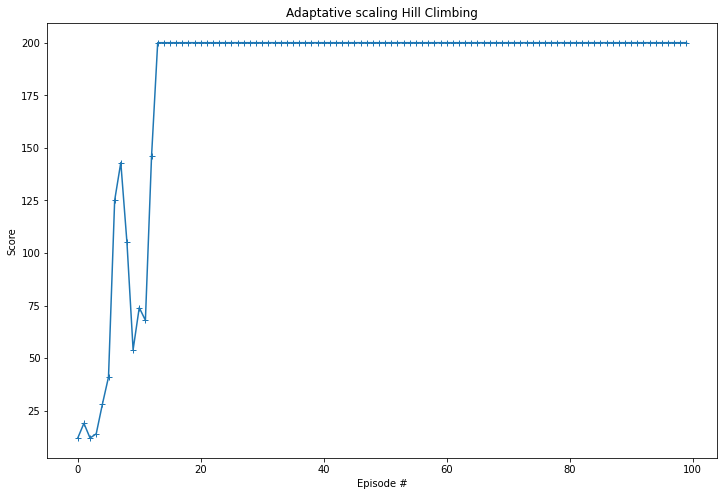

In [239]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_record))*AVERAGE_ON_RECORD, scores_record, marker='+')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Adaptative scaling Hill Climbing')
plt.show()

### Steepest Acent Hill Climbing

#### Vanilla Steepest Acent Hill Climbing

In [294]:
%%time

policy = Policy(state_size=4, action_size=2, hiden_layer_size=8)

#---- hypp

SCALE = .5
N_GENERATION = 5
N_EPISODE = 50
AVERAGE_ON_RECORD = 1

#----

scores_record = deque()
scores_window = deque(maxlen=AVERAGE_ON_RECORD)

best_score = 0
best_generation = -1

for episode in range(N_EPISODE):

    policy.create_generations(N_GENERATION, SCALE)
    
    for i_gen in range(len(policy.generations)):
        
        score = 0
        done = False
        state = env.reset()
        while not done:
            action = policy.act_with_generation(state, i_gen)
            next_state, reward, done, info = env.step(action)
            state = next_state
            score += reward
    
        if score >= best_score:
            best_score = score
            best_generation = i_gen

    if best_generation != -1:
        policy.best_w = policy.generations[best_generation]
        best_generation = -1
    
    scores_window.append(score)
    if len(scores_window) == AVERAGE_ON_RECORD:
        scores_record.append(np.mean(scores_window))
        scores_window = deque()

Wall time: 2.51 s


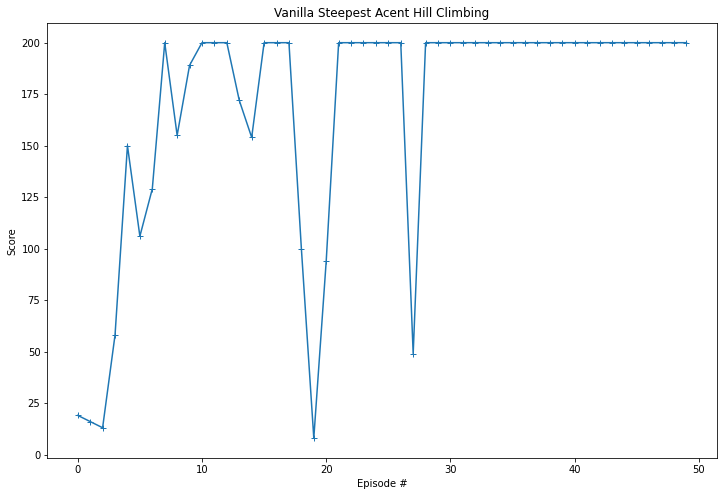

In [295]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_record))*AVERAGE_ON_RECORD, scores_record, marker='+')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Vanilla Steepest Acent Hill Climbing')
plt.show()

#### Steepest Acent  Hill Climbing simulated anneling

In [287]:
%%time

policy = Policy(state_size=4, action_size=2, hiden_layer_size=8)

#---- hypp

N_GENERATION = 5
N_EPISODE = 50
AVERAGE_ON_RECORD = 1
SCALE_INIT = 1
SCALE_UPDATE = .95
SCALE_MIN = 1e-4

#----

scores_record = deque()
scores_window = deque(maxlen=AVERAGE_ON_RECORD)

scale = SCALE_INIT

best_score = 0
best_generation = -1

for episode in range(N_EPISODE):

    policy.create_generations(N_GENERATION, scale)
    
    for i_gen in range(len(policy.generations)):
        
        score = 0
        done = False
        state = env.reset()
        while not done:
            action = policy.act_with_generation(state, i_gen)
            next_state, reward, done, info = env.step(action)
            state = next_state
            score += reward
    
        if score >= best_score:
            best_score = score
            best_generation = i_gen
    
    scale = max(scale * SCALE_UPDATE, SCALE_MIN)
    
    if best_generation != -1:
        policy.best_w = policy.generations[best_generation]
        best_generation = -1
    
    scores_window.append(score)
    if len(scores_window) == AVERAGE_ON_RECORD:
        scores_record.append(np.mean(scores_window))
        scores_window = deque()

Wall time: 2.68 s


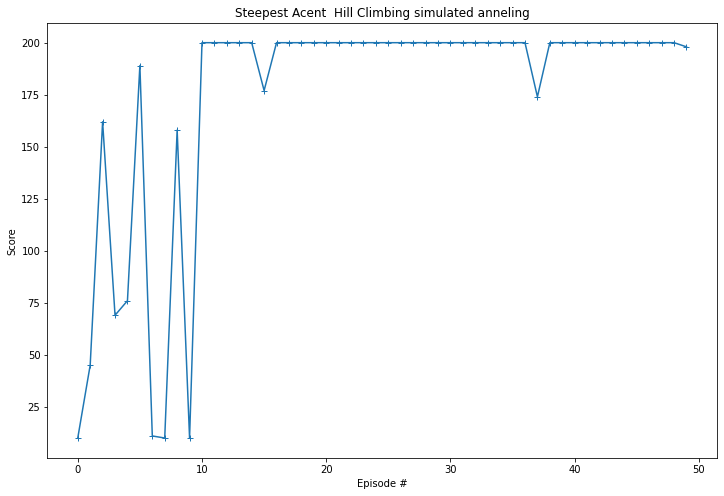

In [289]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_record))*AVERAGE_ON_RECORD, scores_record, marker='+')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Steepest Acent  Hill Climbing simulated anneling')
plt.show()

#### Steepest Acent  Hill Climbing adaptative scale

In [284]:
%%time

policy = Policy(state_size=4, action_size=2, hiden_layer_size=8)

#---- hypp

N_GENERATION = 5
N_EPISODE = 100
AVERAGE_ON_RECORD = 1
SCALE_INIT = .5
SCALE_UPDATE = 1.5
SCALE_MIN = 1e-4
SCALE_MAX = 2

#----

scores_record = deque()
scores_window = deque(maxlen=AVERAGE_ON_RECORD)

scale = SCALE_INIT

best_score = 0
best_generation = -1

for episode in range(N_EPISODE):

    policy.create_generations(N_GENERATION, scale)
    
    for i_gen in range(len(policy.generations)):
        
        score = 0
        done = False
        state = env.reset()
        while not done:
            action = policy.act_with_generation(state, i_gen)
            next_state, reward, done, info = env.step(action)
            state = next_state
            score += reward
    
        if score >= best_score:
            best_score = score
            best_generation = i_gen
    
    if best_generation != -1:
        policy.best_w = policy.generations[best_generation]
        best_generation = -1
        scale = max(scale / SCALE_UPDATE, SCALE_MIN)
    else:
        scale = min(scale * SCALE_UPDATE, SCALE_MAX)
    
    scores_window.append(score)
    if len(scores_window) == AVERAGE_ON_RECORD:
        scores_record.append(np.mean(scores_window))
        scores_window = deque()

Wall time: 5.36 s


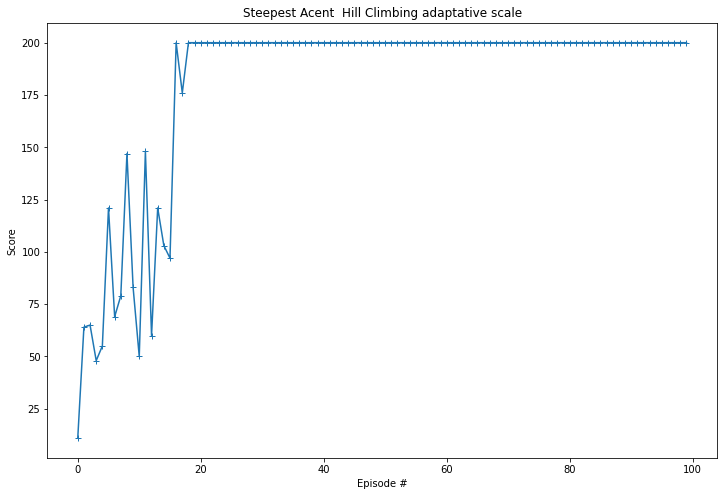

In [286]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_record))*AVERAGE_ON_RECORD, scores_record, marker='+')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Steepest Acent  Hill Climbing adaptative scale')
plt.show()